## CS-GY 6053: Foundations of Data Science

*"Causal Impact of Weather Conditions on Food Delivery Times: Addressing Traffic Density as a Confounding Factor"*

Group : Akshat Singh (as20255), Abha Wadijkar (aw5399), Shweta Shekhar (ss19623)

## Introduction

#### Background

This project investigates the causal effect of weather conditions on delivery times, with traffic density acting as a confounding variable in this relationship. In food delivery logistics, customer satisfaction heavily depends on timely delivery, which is influenced by external factors like weather and traffic. Poor weather conditions can directly slow down delivery times due to reduced visibility and hazardous road conditions. Simultaneously, adverse weather can increase traffic congestion, which indirectly delays deliveries.

#### Problem Statement (question/estimand)

The primary research question driving this study is: **How do weather conditions causally influence food delivery times, with traffic density acting as a confounding factor in this relationship?** By addressing this question, the analysis aims to uncover actionable insights to optimize delivery operations under diverse external scenarios like weather and traffic density.

#### Data Description

The dataset used in this project is sourced from Kaggle and focuses on delivery times under varying external conditions. The 100 data points were selected to ensure diversity across weather and traffic conditions, providing sufficient variation for causal inference. The dataset includes key variables such as:

- **Delivery Time (`time`)**: The time taken for a delivery, measured in minutes, serving as the primary **outcome variable** in the causal model.
- **Weather Conditions (`weather`)**: Categorical descriptions of weather, treated as the **treatment variable** in the causal model. The categories include:
  - Cloudy
  - Fog
  - Sandstorms
  - Stormy
  - Sunny
  - Windy
- **Traffic Density (`traffic`)**: The level of traffic at the time of delivery, which acts as a **potential confounder** in the causal relationship between weather and delivery time. The categories include:
  - High
  - Low
  - Medium

---

In [1]:
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
from scipy.stats import norm, expon
import networkx as nx
import numpy as np
import seaborn as sns

az.rcParams["stats.hdi_prob"] = 0.89 
rnd_seed = 111

---

## Causal Model

#### Causal Model Description
  The model represents the assumed causal relationships between variables: `weather`, `traffic`, and `time`. It is visually represented using a Directed Acyclic Graph (DAG). The primary objective of this analysis is to estimate both the **direct effect** and the **total effect** of `weather` on `time`.

#### Causal Pathways

1. **Direct Effect (Weather → Traffic)**:  
   The variable `weather` is assumed to have a direct causal influence on `traffic`. For instance, adverse weather may lead to increased traffic density.

2. **Direct Effect (Weather → Time)**:  
   The variable `weather` directly affects `time`. Poor weather conditions may slow down travel, leading to longer delivery durations.

3. **Direct Effect (Traffic → Time)**:  
   The variable `traffic` is assumed to have a direct causal effect on `time`. High traffic density generally increases delivery time.

4. **Mediated (Indirect) Effect (Weather → Traffic → Time)**:  
   The variable `weather` also has an **indirect effect** on `time`, mediated by `traffic`. Poor weather can increase traffic congestion, which in turn increases delivery time.

#### Variable Descriptions
  - `weather`: Categorical variable describing weather conditions.
  - `traffic`: Categorical variable describing traffic density.
  - `time`: Continuous variable representing delivery time.

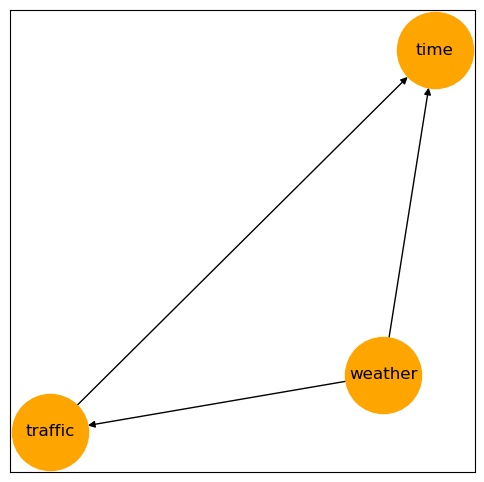

In [2]:
graph = nx.DiGraph()
graph.add_edges_from([
    ("weather", "traffic"), 
    ("weather", "time"), 
    ("traffic","time")])
plt.figure(figsize=(6, 6))
nx.draw_networkx(graph, arrows=True, node_size=3000, node_color="orange")
plt.show()

---

In [3]:
def standardize(series):
    return (series - series.mean()) / series.std()

In [4]:
df_food_delivery = pd.read_csv("food_delivery_data.csv")
df_food_delivery

,weather,traffic,time
0,Cloudy,High,31.0
1,Cloudy,High,29.0
2,Cloudy,High,37.0
3,Cloudy,High,32.0
4,Cloudy,High,25.0
...,...,...,...
95,Windy,Medium,30.0
96,Windy,Medium,29.0
97,Windy,Medium,26.0
98,Windy,Medium,31.0


In [5]:
df_food_delivery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   weather  100 non-null    object 
 1   traffic  100 non-null    object 
 2   time     100 non-null    float64
dtypes: float64(1), object(2)
memory usage: 2.5+ KB


In [6]:
df_food_delivery["time"] = standardize(df_food_delivery["time"])

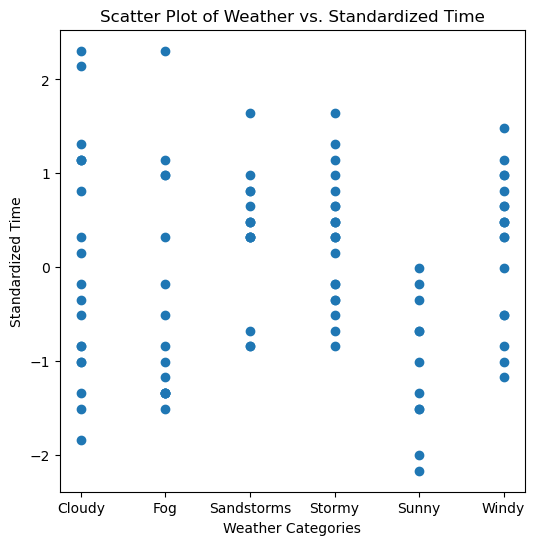

In [7]:
plt.figure(figsize=(6, 6))
plt.scatter(x=df_food_delivery["weather"],y=df_food_delivery["time"])
plt.title("Scatter Plot of Weather vs. Standardized Time")
plt.xlabel("Weather Categories")
plt.ylabel("Standardized Time")
plt.show()

/opt/conda/envs/fnds/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


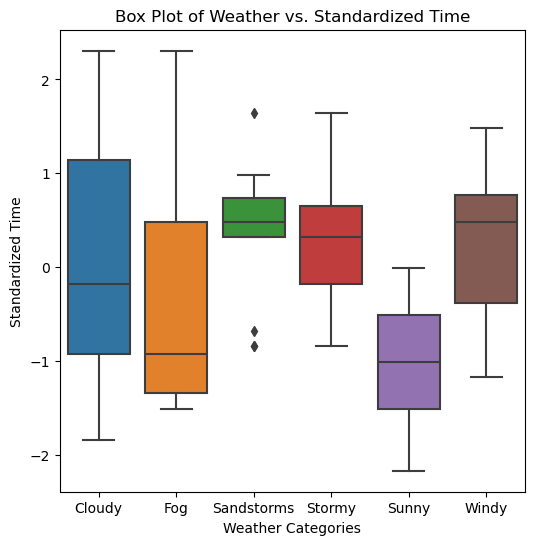

In [72]:
plt.figure(figsize=(6, 6))
sns.boxplot(x=df_food_delivery["weather"],y=df_food_delivery["time"])
plt.title("Box Plot of Weather vs. Standardized Time")
plt.xlabel("Weather Categories")
plt.ylabel("Standardized Time")
plt.show()

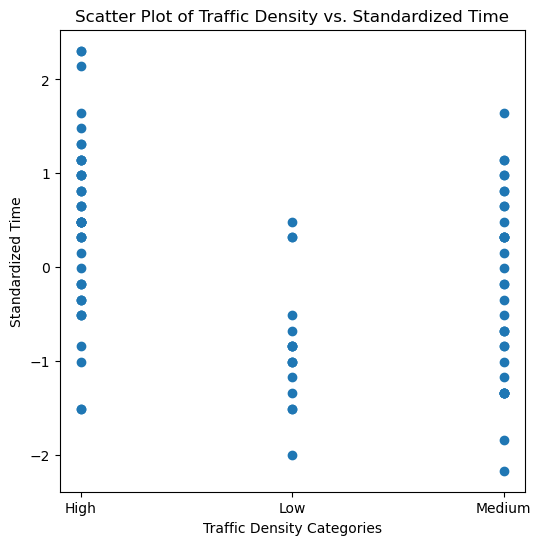

In [9]:
plt.figure(figsize=(6, 6))
plt.scatter(x=df_food_delivery["traffic"],y=df_food_delivery["time"])
plt.title("Scatter Plot of Traffic Density vs. Standardized Time")
plt.xlabel("Traffic Density Categories")
plt.ylabel("Standardized Time")
plt.show()

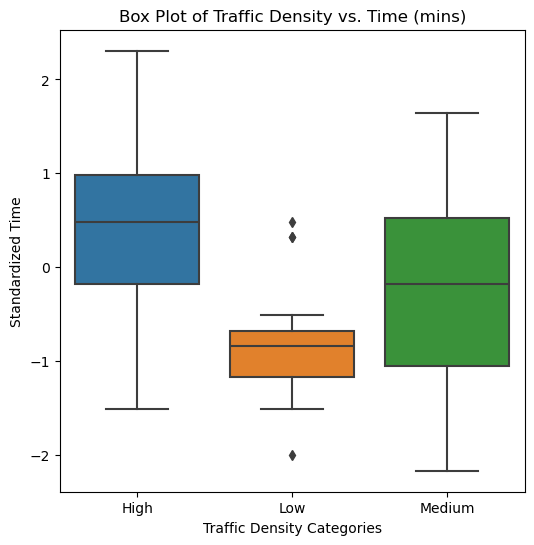

In [10]:
plt.figure(figsize=(6, 6))
sns.boxplot(x=df_food_delivery["traffic"],y=df_food_delivery["time"])
plt.title("Box Plot of Traffic Density vs. Time (mins)")
plt.xlabel("Traffic Density Categories")
plt.ylabel("Standardized Time")
plt.show()

In [11]:
df_food_delivery["weather"] = pd.Categorical(df_food_delivery["weather"])
df_food_delivery["traffic"] = pd.Categorical(df_food_delivery["traffic"])

df_food_delivery

,weather,traffic,time
0,Cloudy,High,1.145864
1,Cloudy,High,0.814210
2,Cloudy,High,2.140825
3,Cloudy,High,1.311690
4,Cloudy,High,0.150902
...,...,...,...
95,Windy,Medium,0.980037
96,Windy,Medium,0.814210
97,Windy,Medium,0.316729
98,Windy,Medium,1.145864


In [12]:
print(dict(enumerate(pd.Categorical(df_food_delivery["weather"]).categories)))
print(dict(enumerate(pd.Categorical(df_food_delivery["traffic"]).categories)))

{0: 'Cloudy', 1: 'Fog', 2: 'Sandstorms', 3: 'Stormy', 4: 'Sunny', 5: 'Windy'}
{0: 'High', 1: 'Low', 2: 'Medium'}


---

##  Statistical Model (Total Effect of `weather` on `time`)

#### Description of the Statistical Model 

The statistical model is described as:

1. **Mathematical Representation**:
   - $\mu_i = \alpha[w]$
   - $\text{time}_i \sim \text{Normal}(\mu_i, \sigma)$
   - Where:
     - $\mu_i$: Expected delivery time for observation $i$, determined by the weather condition.
     - $\alpha[w]$: Weather-specific effects for weather category $w$.
     - $\sigma$: Residual standard deviation, accounting for variability not explained by weather.

2. **Priors**:
   - $\alpha[w] \sim \text{Normal}(0, 0.5)$: Reflecting moderate weather-specific deviations.
   - $\sigma \sim \text{Exponential}(0.5)$: Capturing unexplained variability in standardized time.

The statistical model is fully specified and includes both the priors and likelihood.

---

#### Justification for Priors 

$\alpha[w] \sim \text{Normal}(0, 0.5)$:
The normal distribution is appropriate for modeling continuous weather-specific effects due to its symmetry and flexibility.
A mean of $0$ centers the effects around a neutral baseline, ensuring no prior bias towards any particular weather condition.
The standard deviation of $0.5$ restricts the range of plausible values to moderate deviations, reflecting realistic weather-related variability in delivery times.
Prior predictive simulations confirm that this prior generates plausible delivery times centered around the standardized mean of $0$ with variability consistent with observed data.

$\sigma \sim \text{Exponential}(0.5)$:
The exponential distribution is a natural choice for modeling positive quantities like standard deviations due to its non-negativity and flexibility.
A scale parameter of $0.5$ reflects the expectation of smaller residual variability, consistent with the standardized dataset where most deviations are relatively moderate.
Prior predictive checks confirm that this prior allows the model to capture unexplained variability effectively while constraining excessive noise, ensuring the predictions remain realistic and interpretable.

---

#### Prior Predictive Checks

To validate the priors, we performed prior predictive simulations based on the statistical model. The priors for the weather-specific effects ($\alpha[w]$) were drawn from a $\text{Normal}(0, 0.5)$, and the residual standard deviation ($\sigma$) was drawn from an $\text{Exponential}(0.5)$. The resulting simulations generated plausible delivery times, consistent with a standardized dataset where the mean is approximately $0$, and variability is scaled.

These results suggest the priors are reasonable for the context of this analysis, as they allow moderate deviations due to weather while maintaining realistic predictions.

---

#### Justification for the Outcome Distribution

The outcome variable (`time`) is continuous and approximately symmetric due to standardization. A normal distribution is appropriate for modeling such data, as it can capture the central tendency and variability in delivery times. The inclusion of $\sigma$ as the residual standard deviation accounts for unexplained variability, further supporting the choice of the distribution.

---

#### Alignment with the Causal Model

The statistical model aligns with the assumed causal model by isolating the **total effect** of `weather` on `time`. We $\alpha[w]$ as the expected delivery time for each weather category. This directly addresses the research question, "What is the total effect of weather on delivery time?" Indirect pathways (e.g., mediated by `traffic`) are not explicitly included, as this model focuses solely on the total effect.

---

#### Confounder Handling

This model estimates the total effect of `weather` on `time`, so confounders like `traffic` are not explicitly adjusted for. This is appropriate for the causal question being addressed. A separate model would be required to estimate the **direct effect** of weather while controlling for potential confounders.

---

#### Prior Predictive Simulation

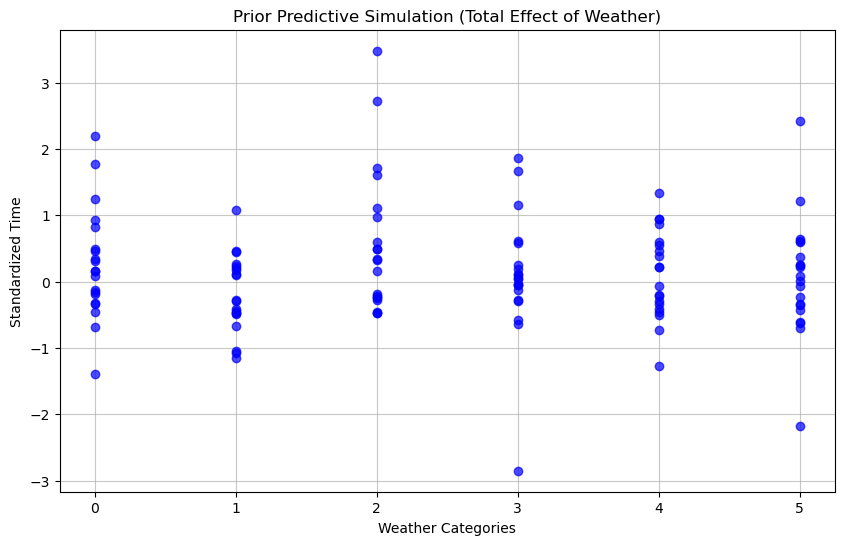

In [13]:
n = 20 
n_weather = len(df_food_delivery["weather"].unique())  

alpha = norm.rvs(0, 0.5, size=(n, n_weather)) 
sigma = expon.rvs(scale=0.5, size=n)

weather_seq = np.arange(n_weather)

plt.figure(figsize=(10, 6))
for i in range(n):  
    for w in weather_seq:  
        mu = alpha[i, w]  
        time = norm.rvs(mu, sigma[i])  
        plt.plot(w, time, 'o', color="blue", alpha=0.7)

plt.title("Prior Predictive Simulation (Total Effect of Weather)")
plt.xlabel("Weather Categories")
plt.ylabel("Standardized Time")
plt.grid(True, alpha=0.7)
plt.show()

---

#### Evaluating Statistical Model on Simulated Data

In [14]:
np.random.seed(rnd_seed)

n_weather = len(df_food_delivery["weather"].unique()) 

weather_idx = np.random.choice(n_weather, size=1000)
alpha = norm.rvs(0, 0.5, size=n_weather)  
sigma = 0.5  

# simulate true mean (mu) and observed times (time)
mu = alpha[weather_idx]
time = norm.rvs(mu, sigma, size=1000)

with pm.Model() as statistical_model_total_effect:
    alpha = pm.Normal("alpha", mu=0, sigma=0.5, shape=n_weather)  
    scale = 0.5
    s = pm.Exponential("sigma", lam=1/scale)  
    mu = pm.Deterministic("mu", alpha[weather_idx]) # predicted mean
    time = pm.Normal("time", mu=mu, sigma=s, observed=time)
    idata_statistical_model_total_effect = pm.sample(random_seed=rnd_seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [15]:
az.summary(idata_statistical_model_total_effect, var_names=["alpha", "sigma"])

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.019,0.039,-0.078,0.042,0.001,0.001,2903.0,1685.0,1.0
alpha[1],-1.240,0.037,-1.300,-1.185,0.001,0.000,3706.0,1525.0,1.0
alpha[2],-0.141,0.039,-0.200,-0.076,0.001,0.001,2784.0,1414.0,1.0
alpha[3],-0.530,0.038,-0.591,-0.470,0.001,0.001,2411.0,1480.0,1.0
alpha[4],-0.317,0.038,-0.374,-0.253,0.001,0.000,3145.0,1584.0,1.0
alpha[5],0.340,0.037,0.284,0.402,0.001,0.001,2537.0,1261.0,1.0
sigma,0.502,0.011,0.483,0.519,0.000,0.000,1951.0,1397.0,1.0


---

## Statistical Model - Direct Effect of `weather` on `time`

#### Description of the Statistical Model

The statistical model is described as:

1. **Mathematical Representation**:
   - $\mu_i = \alpha[w, t]$
   - $\text{time}_i \sim \text{Normal}(\mu_i, \sigma)$
   - Where:
     - $\mu_i$: Expected delivery time for observation $i$, determined by the weather condition and traffic level.
     - $\alpha[w, t]$: Effects of weather category $w$ and traffic category $t$.
     - $\sigma$: Residual standard deviation, accounting for variability not explained by weather and traffic.

2. **Priors**:
   - $\alpha[w, t] \sim \text{Normal}(0, 0.5)$: Reflecting moderate weather and traffic effects.
   - $\sigma \sim \text{Exponential}(0.5)$: Capturing unexplained variability in standardized time.

The statistical model is fully specified and includes both the priors and likelihood.

---

#### Justification for Priors 

$\alpha[w, t] \sim \text{Normal}(0, 0.5)$:  
The normal distribution is appropriate for modeling this effect due to its symmetry and flexibility.  
A mean of $0$ centers the effects around a neutral baseline, ensuring no prior bias towards any particular weather or traffic condition.  
The standard deviation of $0.5$ restricts the range of plausible values to moderate deviations, reflecting realistic weather and traffic related variability in delivery times.  
Prior predictive simulations confirm that this prior generates plausible delivery times centered around the standardized mean of $0$ with variability consistent with observed data.

$\sigma \sim \text{Exponential}(0.5)$:  
The exponential distribution is a natural choice for modeling positive quantities like standard deviations due to its non-negativity and flexibility.  
A scale parameter of $0.5$ reflects the expectation of smaller residual variability, consistent with the standardized dataset where most deviations are relatively moderate.  
Prior predictive checks confirm that this prior allows the model to capture unexplained variability effectively while constraining excessive noise, ensuring the predictions remain realistic and interpretable.

---

#### Prior Predictive Checks

To validate the priors, we performed prior predictive simulations based on the statistical model. The priors for the effects ($\alpha[w, t]$) were drawn from a $\text{Normal}(0, 0.5)$, and the residual standard deviation ($\sigma$) was drawn from an $\text{Exponential}(0.5)$. The resulting simulations generated plausible delivery times, consistent with a standardized dataset where the mean is approximately $0$, and variability is scaled.

These results suggest the priors are reasonable for the context of this analysis, as they allow moderate deviations due to weather and traffic while maintaining realistic predictions.

---

#### Justification for the Outcome Distribution

The outcome variable (`time`) is continuous and approximately symmetric due to standardization. A normal distribution is appropriate for modeling such data, as it can capture the central tendency and variability in delivery times. The inclusion of $\sigma$ as the residual standard deviation accounts for unexplained variability, further supporting the choice of the distribution.

---

#### Alignment with the Causal Model

The statistical model aligns with the assumed causal model by estimating the **direct effect** of `weather` on `time`, while accounting for `traffic` as a confounder. We estimate $\alpha[w, t]$ as the expected delivery time for each combination of weather category and traffic category. This directly addresses the research question, "What is the direct effect of weather on delivery time while controlling for traffic?"

---

#### Confounder Handling

This model explicitly adjusts for `traffic` by including it in the term ($\alpha[w, t]$).

---

#### Prior Predictive Simulation

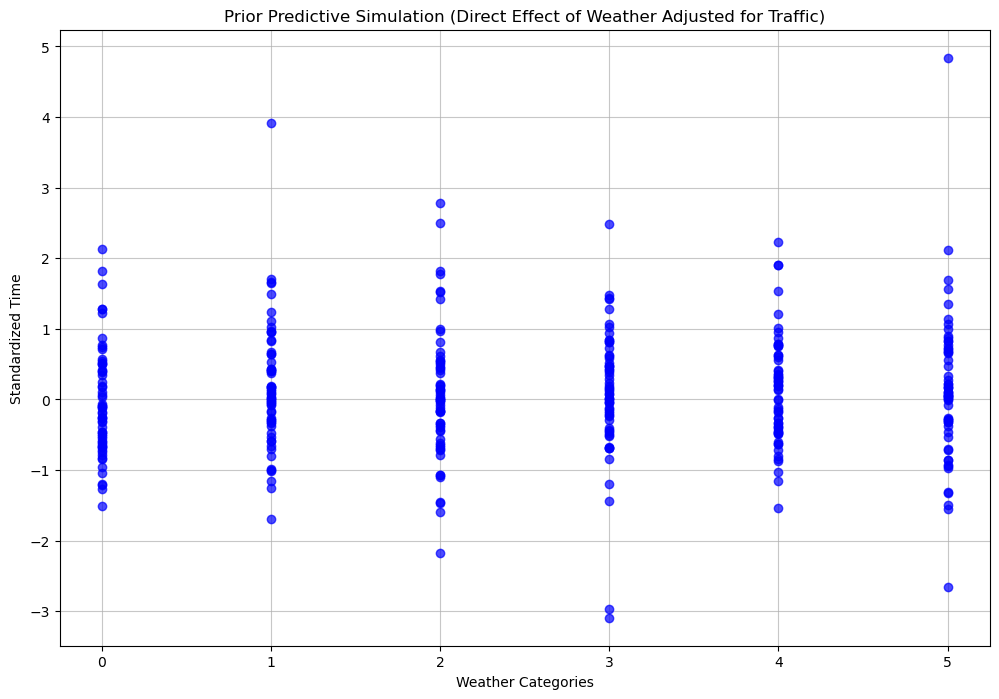

In [16]:
n_traffic = len(df_food_delivery["traffic"].unique())
traffic_seq = np.arange(n_traffic)

alpha = norm.rvs(0, 0.5, size=(n, n_weather, n_traffic))
sigma = expon.rvs(scale=0.5, size=n)

plt.figure(figsize=(12, 8))
for i in range(n):
    for w in weather_seq:
        for t in traffic_seq:
            mu = alpha[i, w, t]  
            time = norm.rvs(mu, sigma[i])
            plt.plot(w, time, 'o', color="blue", alpha=0.7)  
            
plt.title("Prior Predictive Simulation (Direct Effect of Weather Adjusted for Traffic)")
plt.xlabel("Weather Categories")
plt.ylabel("Standardized Time")
plt.grid(True, alpha=0.7)
plt.show()

---

#### Evaluating Statistical Model on Simulated Data

In [44]:
np.random.seed(rnd_seed)

n_weather = len(df_food_delivery["weather"].unique())
n_traffic = len(df_food_delivery["traffic"].unique())

weather_idx = np.random.choice(n_weather, size=1000)
traffic_idx = np.random.choice(n_traffic, size=1000)

alpha = norm.rvs(0, 0.5, size=(n_weather, n_traffic))
sigma = 0.5

mu = alpha[weather_idx, traffic_idx]
time = norm.rvs(mu, sigma, size=1000)

with pm.Model() as statistical_model_direct_effect:
    alpha = pm.Normal("alpha", mu=0, sigma=0.5, shape=(n_weather, n_traffic))
    scale = 0.5
    s = pm.Exponential("sigma", lam=1/scale)
    mu = pm.Deterministic("mu", alpha[weather_idx, traffic_idx])
    time = pm.Normal("time", mu=mu, sigma=s, observed=time)
    idata_statistical_model_direct_effect = pm.sample(random_seed=rnd_seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [45]:
az.summary(idata_statistical_model_direct_effect, var_names=["alpha", "sigma"])

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"alpha[0, 0]",-0.758,0.069,-0.861,-0.642,0.001,0.001,4611.0,1469.0,1.00
"alpha[0, 1]",-0.021,0.065,-0.119,0.085,0.001,0.002,4152.0,1388.0,1.00
"alpha[0, 2]",0.694,0.071,0.583,0.806,0.001,0.001,4776.0,1550.0,1.00
"alpha[1, 0]",-0.496,0.068,-0.605,-0.388,0.001,0.001,4820.0,1570.0,1.01
"alpha[1, 1]",0.665,0.068,0.556,0.771,0.001,0.001,4024.0,1178.0,1.00
"alpha[1, 2]",-0.605,0.068,-0.714,-0.501,0.001,0.001,4562.0,1707.0,1.00
"alpha[2, 0]",-0.375,0.071,-0.484,-0.258,0.001,0.001,4017.0,1400.0,1.00
"alpha[2, 1]",-0.721,0.069,-0.833,-0.609,0.001,0.001,3788.0,1490.0,1.00
"alpha[2, 2]",-0.048,0.066,-0.155,0.055,0.001,0.001,4731.0,1471.0,1.00
"alpha[3, 0]",-0.390,0.067,-0.489,-0.278,0.001,0.001,3332.0,1440.0,1.00


---

## Posterior Model - Total Effect of `weather` on `time`

In [46]:
with pm.Model() as posterior_model_total_effect:
    weather_idx = pd.Categorical(df_food_delivery["weather"]).codes  
    time = df_food_delivery["time"] 

    alpha = pm.Normal("alpha", mu=0, sigma=0.5, shape=(len(np.unique(weather_idx))))
    scale = 0.5
    sigma = pm.Exponential("sigma", lam=1/scale)  # Standard deviation
    
    mu = pm.Deterministic("mu", alpha[weather_idx])

    t = pm.Normal("t", mu=mu, sigma=sigma, observed=df_food_delivery["time"])
    
    idata_posterior_model_total_effect = pm.sample(random_seed=rnd_seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [47]:
az.summary(idata_posterior_model_total_effect, var_names=["alpha", "sigma"])

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.049,0.189,-0.255,0.344,0.004,0.004,2094.0,1370.0,1.0
alpha[1],-0.314,0.214,-0.677,0.004,0.004,0.003,2975.0,1894.0,1.0
alpha[2],0.289,0.213,-0.043,0.617,0.004,0.003,3121.0,1749.0,1.0
alpha[3],0.280,0.176,0.025,0.574,0.004,0.003,2043.0,1181.0,1.0
alpha[4],-0.799,0.244,-1.216,-0.448,0.005,0.003,2814.0,1501.0,1.0
alpha[5],0.218,0.197,-0.078,0.536,0.004,0.003,2896.0,1791.0,1.0
sigma,0.920,0.066,0.814,1.017,0.001,0.001,2644.0,1428.0,1.0


#### **Posterior Estimates and Interpretation**
The posterior distributions of the weather effects ($\alpha$) provide insights into how weather conditions influence delivery times, quantifying both the magnitude and uncertainty of each weather condition's impact:

1. **Weather Categories and Their Effects:**

   - **Cloudy ($\alpha[0]$):**  
     - Tends to have **no strong change** on delivery times.  
     - Mean: $0.049$, 89% HDI: $(-0.255, 0.344)$  

   - **Fog ($\alpha[1]$):**  
     - Tends to have a **decrease** in delivery times.  
     - Mean: $-0.314$, 89% HDI: $(-0.677, 0.004)$  

   - **Sandstorms ($\alpha[2]$):**  
     - Tends to have an **increase** in delivery times.  
     - Mean: $0.289$, 89% HDI: $(-0.043, 0.617)$  

   - **Stormy ($\alpha[3]$):**  
     - Tends to have an **increase** in delivery times.  
     - Mean: $0.280$, 89% HDI: $(0.025, 0.574)$  

   - **Sunny ($\alpha[4]$):**  
     - Tends to have a **decrease** in delivery times.  
     - Mean: $-0.799$, 89% HDI: $(-1.216, -0.448)$  

   - **Windy ($\alpha[5]$):**  
     - Tends to have an **increase** in delivery times.  
     - Mean: $0.218$, 89% HDI: $(-0.078, 0.536)$  

2. **Residual Variability ($\sigma$):**  
   - Mean: $0.920$, 89% HDI: $(0.814, 1.017)$  

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

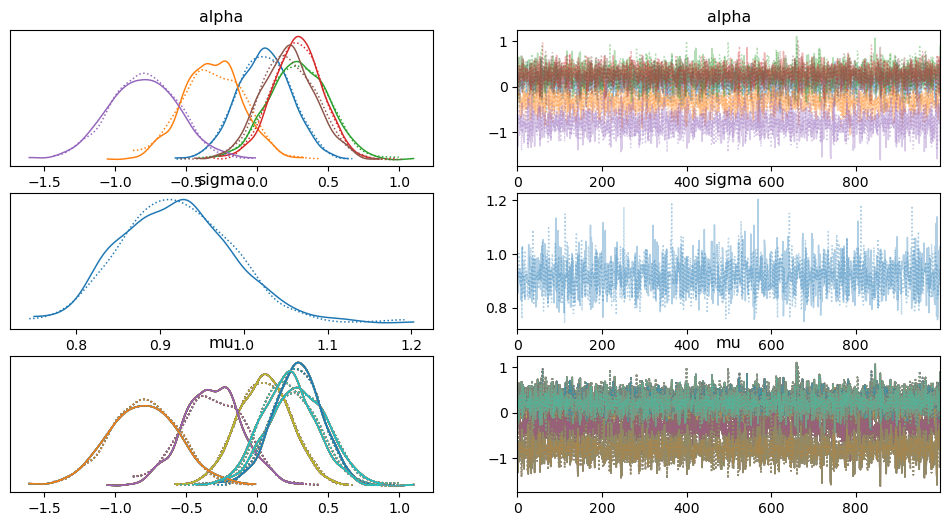

In [48]:
az.plot_trace(idata_posterior_model_total_effect)

array([[<Axes: title={'center': 'alpha\n0'}>,
        <Axes: title={'center': 'alpha\n1'}>,
        <Axes: title={'center': 'alpha\n2'}>],
       [<Axes: title={'center': 'alpha\n3'}>,
        <Axes: title={'center': 'alpha\n4'}>,
        <Axes: title={'center': 'alpha\n5'}>]], dtype=object)

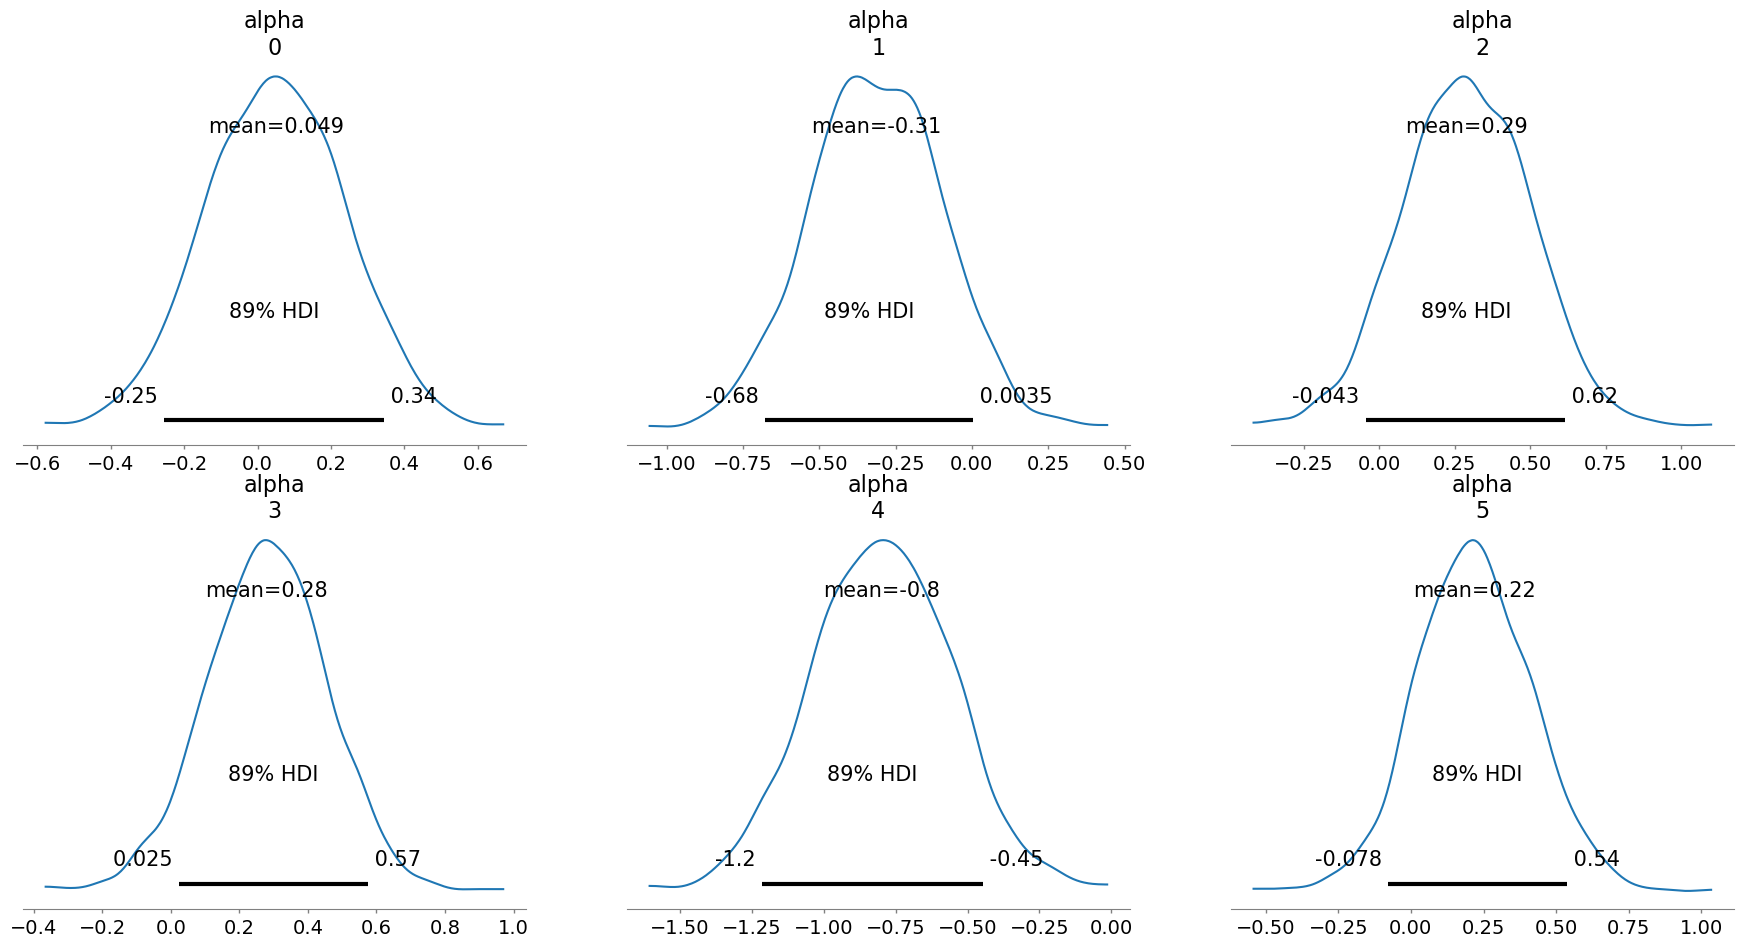

In [49]:
az.plot_posterior(idata_posterior_model_total_effect, var_names = ["alpha"])

In [50]:
np.array(az.rhat(idata_posterior_model_total_effect, var_names=["alpha"])["alpha"])

array([1.00096615, 1.00288558, 0.99980141, 0.99988038, 1.00169955,
       1.00084653])

In [51]:
np.array(az.mcse(idata_posterior_model_total_effect, var_names=["alpha"])["alpha"])

array([0.00411469, 0.00394434, 0.00381477, 0.00389116, 0.00459424,
       0.00366095])

In [52]:
np.array(az.ess(idata_posterior_model_total_effect, var_names=["alpha"])["alpha"])

array([2093.54770642, 2974.54668555, 3121.31293295, 2042.63845261,
       2813.91738785, 2896.49675163])

We used ArviZ's built-in diagnostics to assess the quality of the posterior sampling. Below are the diagnostics used and their interpretations based on the official definitions:

##### R-hat (Rank Normalized Split R-hat)

The rank normalized R-hat diagnostic tests for a lack of convergence by comparing the variance between multiple chains to the variance within each chain. If convergence has been achieved, the variances should be identical. This diagnostic is most effective when chains are initialized with dispersed starting values relative to the target distribution.

Values Obtained: [1.00096615, 1.00288558, 0.99980141, 0.99988038, 1.00169955,1.00084653]

Interpretation:

R-hat values close to 1 indicate that the chains have converged well. All values are close to 1, confirming convergence for the alpha parameters.

##### MCSE (Monte Carlo Standard Error)

The MCSE statistic measures the standard error of the posterior mean estimate due to finite sampling. It provides an estimate of the uncertainty in the mean of the posterior distribution.

Values Obtained: [0.00411469, 0.00394434, 0.00381477, 0.00389116, 0.00459424,
       0.00366095]

MCSE values are small, indicating that the posterior mean estimates are precise and that the number of samples is sufficient.

##### ESS (Effective Sample Size)

The effective sample size (ESS) measures how many independent samples the posterior effectively represents, taking into account autocorrelation within the chains. High ESS values indicate better sampling efficiency.

Values Obtained: [2093.54770642, 2974.54668555, 3121.31293295, 2042.63845261,
       2813.91738785, 2896.49675163]

High ESS values (all exceeding 2000) demonstrate good sampling efficiency and effective exploration of the posterior distribution.

---

## Posterior Model - Direct Effect of `weather` on `time`

In [53]:
with pm.Model() as posterior_model_direct_effect:
    weather_idx = pd.Categorical(df_food_delivery["weather"]).codes  
    traffic_idx = pd.Categorical(df_food_delivery["traffic"]).codes 
    time = df_food_delivery["time"] 

    d_weather = pm.MutableData("weather", weather_idx)
    d_traffic = pm.MutableData("traffic", traffic_idx)
    d_time = pm.MutableData("time", time)
    
    alpha = pm.Normal("alpha", mu=0, sigma=0.5, shape=(len(np.unique(weather_idx)), len(np.unique(traffic_idx))))
    scale = 0.5
    sigma = pm.Exponential("sigma", 1/scale)  
    
    mu = pm.Deterministic("mu", alpha[d_weather, d_traffic])
    
    t = pm.Normal("t", mu=mu, sigma=sigma, observed=d_time)
    
    idata_posterior_model_direct_effect = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [54]:
az.summary(idata_posterior_model_direct_effect, var_names=["alpha", "sigma"])

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"alpha[0, 0]",0.674,0.194,0.355,0.975,0.003,0.002,4230.0,1437.0,1.00
"alpha[0, 1]",-0.671,0.310,-1.163,-0.185,0.005,0.004,3334.0,1683.0,1.00
"alpha[0, 2]",-0.837,0.286,-1.283,-0.382,0.004,0.003,4381.0,1695.0,1.00
"alpha[1, 0]",0.553,0.235,0.169,0.914,0.004,0.003,3726.0,1485.0,1.00
"alpha[1, 1]",-0.776,0.324,-1.296,-0.266,0.006,0.005,3262.0,1359.0,1.01
"alpha[1, 2]",-0.924,0.247,-1.328,-0.532,0.004,0.003,3355.0,1268.0,1.00
"alpha[2, 0]",0.325,0.229,-0.010,0.721,0.004,0.004,3446.0,1421.0,1.00
"alpha[2, 1]",-0.132,0.351,-0.684,0.420,0.006,0.008,3855.0,1199.0,1.00
"alpha[2, 2]",0.360,0.260,-0.041,0.760,0.004,0.004,4249.0,1544.0,1.00
"alpha[3, 0]",0.563,0.236,0.181,0.928,0.004,0.003,4031.0,1608.0,1.00


#### **Posterior Estimates and Interpretation**

The posterior distributions of the weather effects ($\alpha[i, j]$), where $i$ represents the weather condition and $j$ represents the traffic condition (0: High Traffic, 1: Low Traffic, 2: Medium Traffic), provide insights into how weather conditions and traffic levels influence delivery times, quantifying both the magnitude and direction of each weather condition's impact:

1. **Weather Categories and Their Effects Across Traffic Levels:**

   - **Cloudy ($\alpha[0, j]$):**  
     - **High Traffic ($j=0$):** Tends to have an **increase** in delivery times.  
       - Mean: $0.674$, 89% HDI: $(0.355, 0.975)$  
     - **Low Traffic ($j=1$):** Tends to have a **decrease** in delivery times.  
       - Mean: $-0.671$, 89% HDI: $(-1.163, -0.185)$  
     - **Medium Traffic ($j=2$):** Tends to have a **decrease** in delivery times.  
       - Mean: $-0.837$, 89% HDI: $(-1.283, -0.382)$  

   - **Fog ($\alpha[1, j]$):**  
     - **High Traffic ($j=0$):** Tends to have an **increase** in delivery times.  
       - Mean: $0.553$, 89% HDI: $(0.169, 0.914)$  
     - **Low Traffic ($j=1$):** Tends to have a **decrease** in delivery times.  
       - Mean: $-0.776$, 89% HDI: $(-1.296, -0.266)$  
     - **Medium Traffic ($j=2$):** Tends to have a **decrease** in delivery times.  
       - Mean: $-0.924$, 89% HDI: $(-1.328, -0.532)$  

   - **Sandstorms ($\alpha[2, j]$):**  
     - **High Traffic ($j=0$):** Tends to have an **increase** in delivery times.  
       - Mean: $0.325$, 89% HDI: $(-0.010, 0.721)$  
     - **Low Traffic ($j=1$):** Tends to have **no strong change** in delivery times.  
       - Mean: $-0.132$, 89% HDI: $(-0.684, 0.420)$  
     - **Medium Traffic ($j=2$):** Tends to have an **increase** in delivery times.  
       - Mean: $0.360$, 89% HDI: $(-0.041, 0.760)$  

   - **Stormy ($\alpha[3, j]$):**  
     - **High Traffic ($j=0$):** Tends to have an **increase** in delivery times.  
       - Mean: $0.563$, 89% HDI: $(0.181, 0.928)$  
     - **Low Traffic ($j=1$):** Tends to have **no strong change** in delivery times.  
       - Mean: $-0.097$, 89% HDI: $(-0.553, 0.351)$  
     - **Medium Traffic ($j=2$):** Tends to have **no strong change** in delivery times.  
       - Mean: $0.184$, 89% HDI: $(-0.161, 0.481)$  

   - **Sunny ($\alpha[4, j]$):**  
     - **High Traffic ($j=0$):** Tends to have a **decrease** in delivery times.  
       - Mean: $-0.652$, 89% HDI: $(-1.089, -0.269)$  
     - **Low Traffic ($j=1$):** Tends to have a **decrease** in delivery times.  
       - Mean: $-0.672$, 89% HDI: $(-1.260, -0.121)$  
     - **Medium Traffic ($j=2$):** Tends to have a **decrease** in delivery times.  
       - Mean: $-0.692$, 89% HDI: $(-1.139, -0.188)$  

   - **Windy ($\alpha[5, j]$):**  
     - **High Traffic ($j=0$):** Tends to have an **increase** in delivery times.  
       - Mean: $0.393$, 89% HDI: $(0.054, 0.735)$  
     - **Low Traffic ($j=1$):** Tends to have a **decrease** in delivery times.  
       - Mean: $-0.611$, 89% HDI: $(-1.121, -0.098)$  
     - **Medium Traffic ($j=2$):** Tends to have an **increase** in delivery times.  
       - Mean: $0.422$, 89% HDI: $(0.049, 0.837)$  

2. **Residual Variability ($\sigma$):**  
   - Mean: $0.709$, 89% HDI: $(0.621, 0.795)$   

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

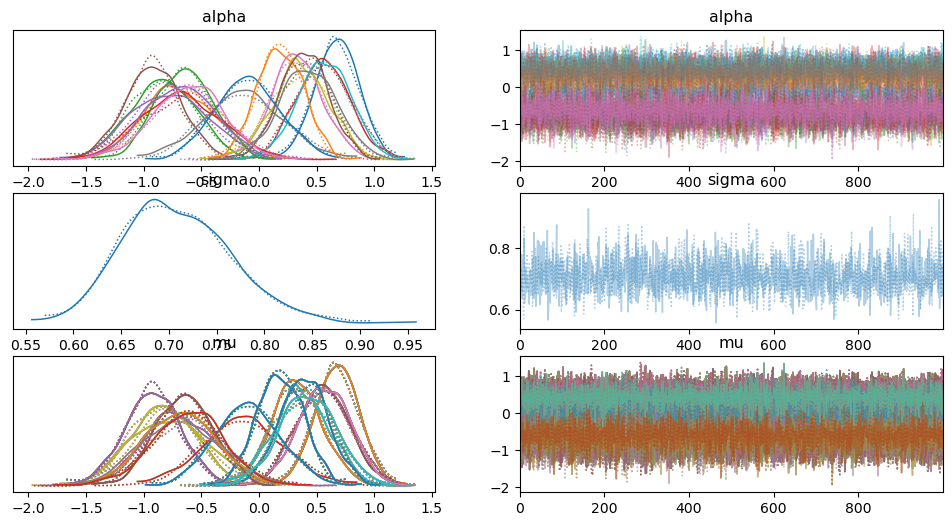

In [55]:
az.plot_trace(idata_posterior_model_direct_effect)

array([[<Axes: title={'center': 'alpha\n0, 0'}>,
        <Axes: title={'center': 'alpha\n0, 1'}>,
        <Axes: title={'center': 'alpha\n0, 2'}>],
       [<Axes: title={'center': 'alpha\n1, 0'}>,
        <Axes: title={'center': 'alpha\n1, 1'}>,
        <Axes: title={'center': 'alpha\n1, 2'}>],
       [<Axes: title={'center': 'alpha\n2, 0'}>,
        <Axes: title={'center': 'alpha\n2, 1'}>,
        <Axes: title={'center': 'alpha\n2, 2'}>],
       [<Axes: title={'center': 'alpha\n3, 0'}>,
        <Axes: title={'center': 'alpha\n3, 1'}>,
        <Axes: title={'center': 'alpha\n3, 2'}>],
       [<Axes: title={'center': 'alpha\n4, 0'}>,
        <Axes: title={'center': 'alpha\n4, 1'}>,
        <Axes: title={'center': 'alpha\n4, 2'}>],
       [<Axes: title={'center': 'alpha\n5, 0'}>,
        <Axes: title={'center': 'alpha\n5, 1'}>,
        <Axes: title={'center': 'alpha\n5, 2'}>]], dtype=object)

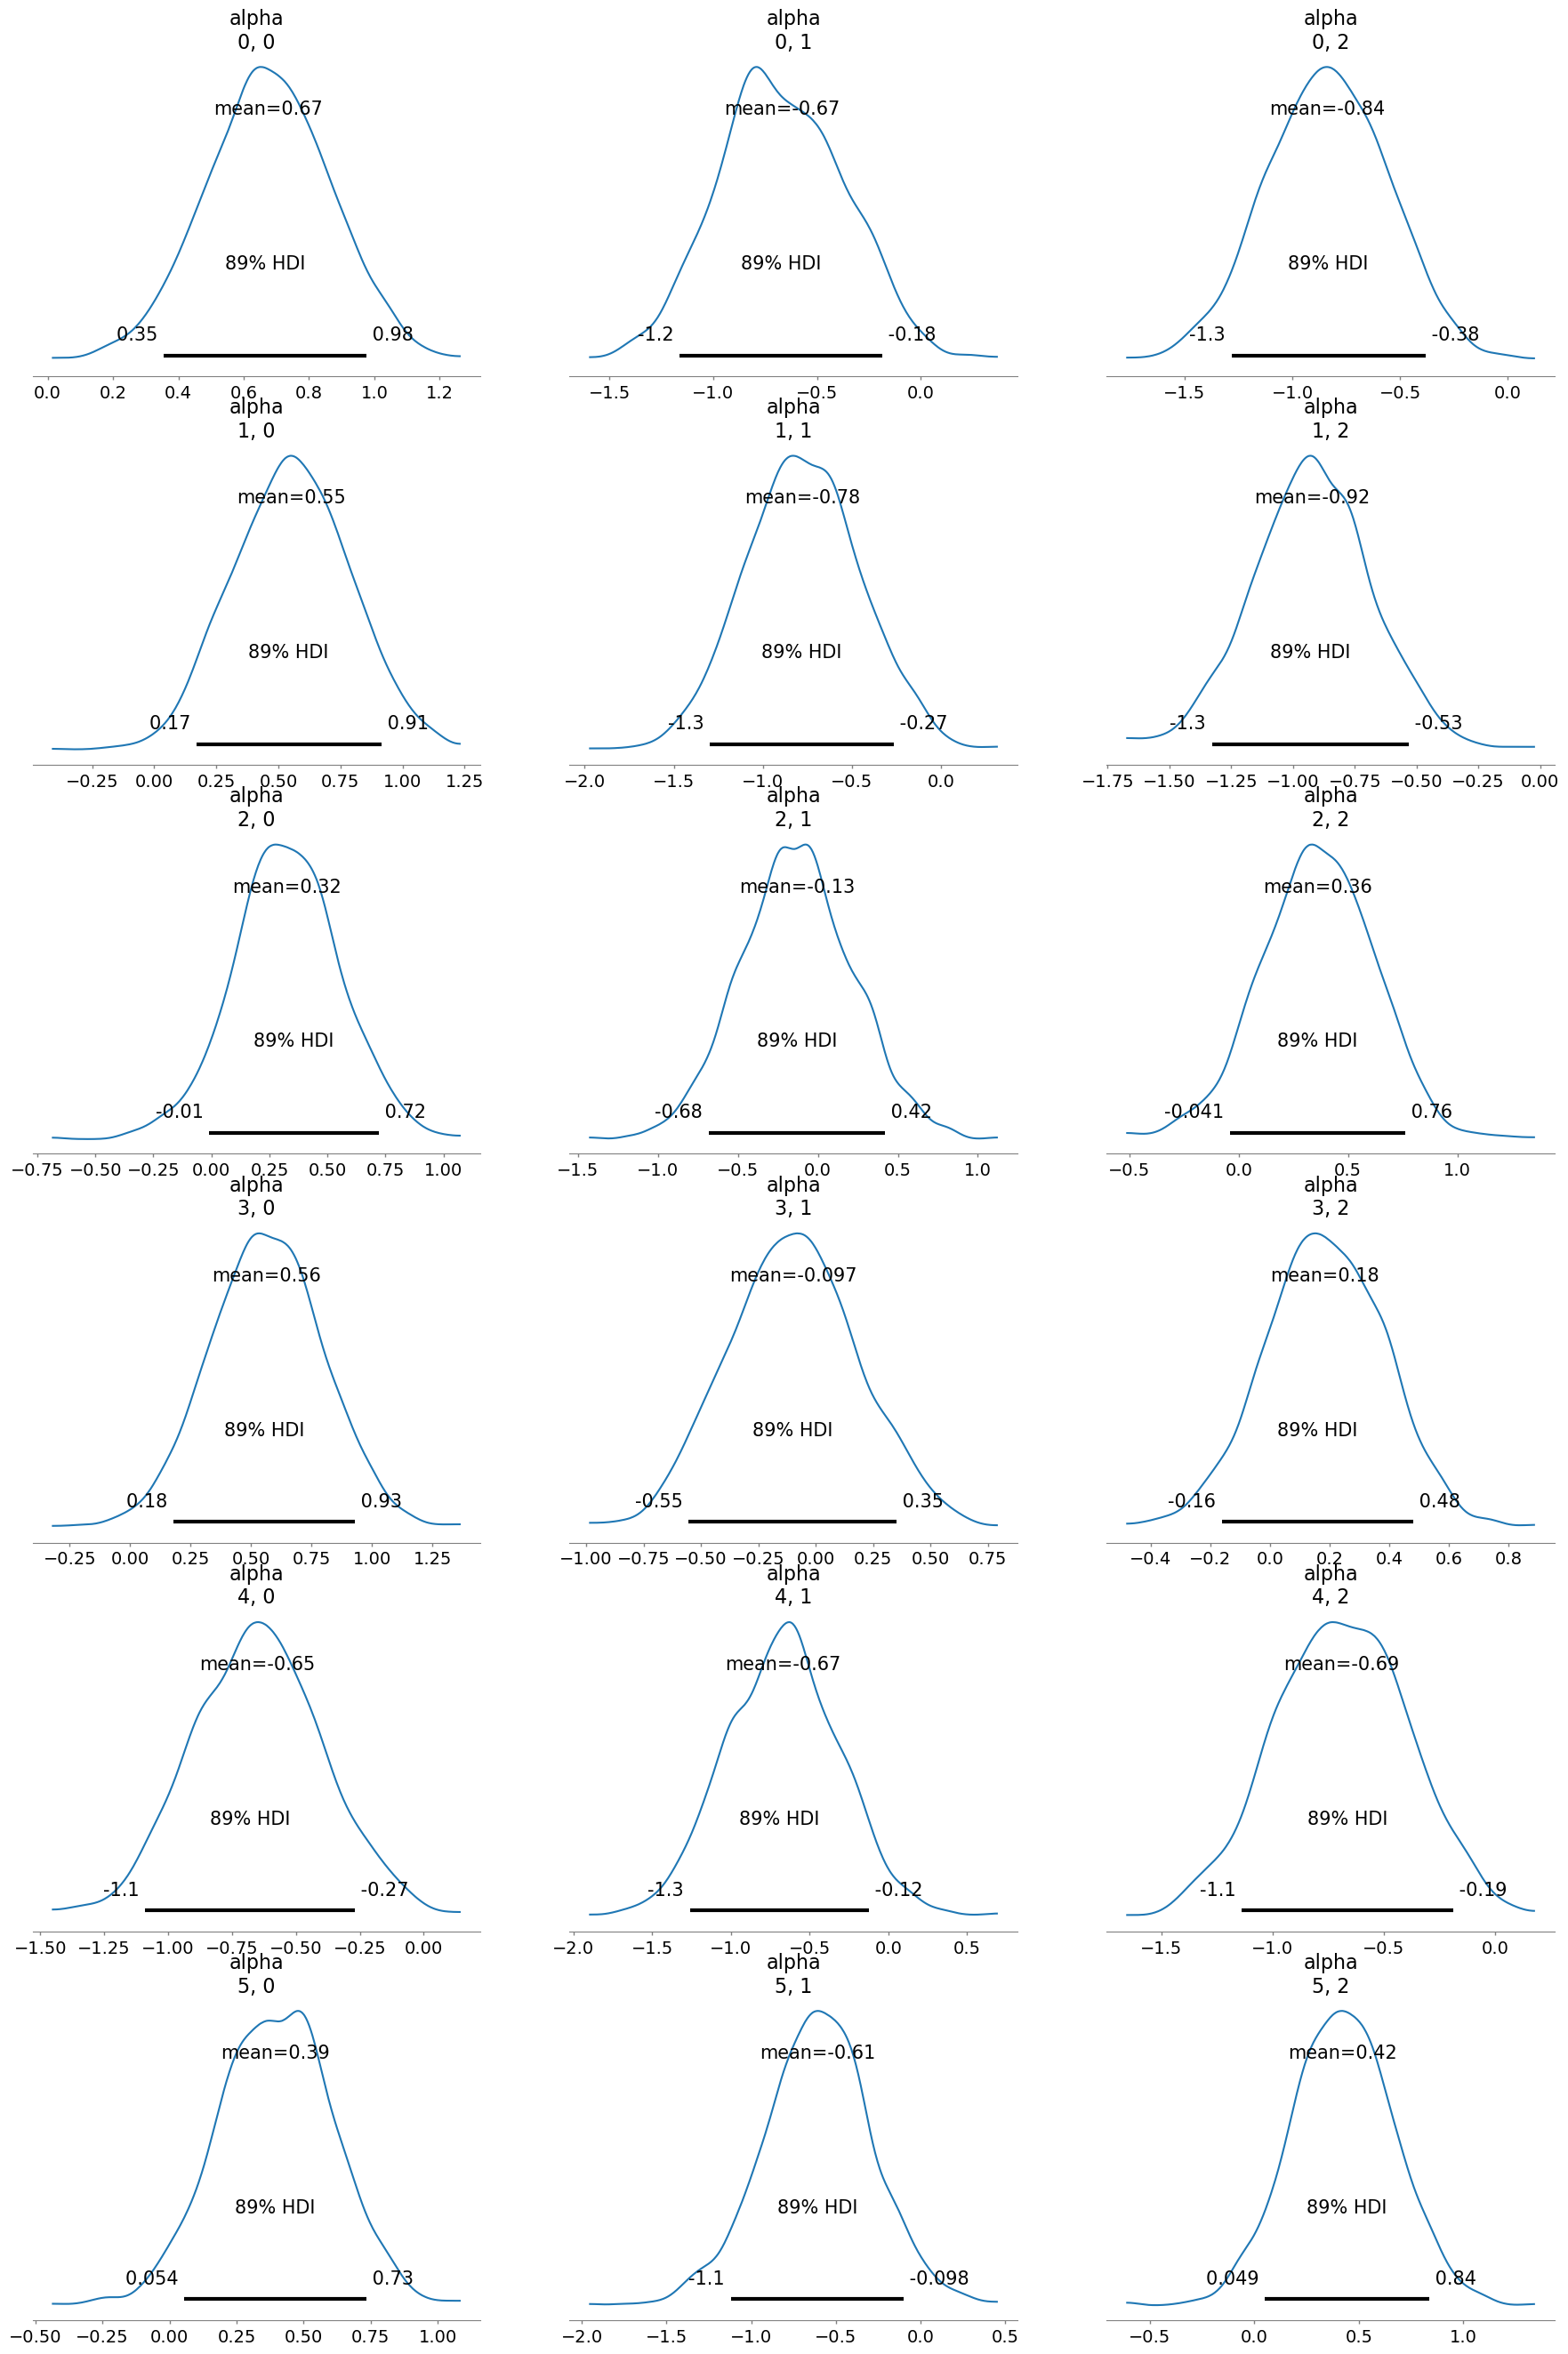

In [56]:
az.plot_posterior(idata_posterior_model_direct_effect, var_names=["alpha"])

In [57]:
np.array(az.rhat(idata_posterior_model_direct_effect, var_names=["alpha"])["alpha"])

array([[1.00097771, 1.00029207, 1.0010588 ],
       [1.00021506, 1.00692822, 1.0026444 ],
       [0.99978774, 1.00010189, 1.0013703 ],
       [0.99955964, 1.00066295, 1.00780016],
       [0.9996819 , 1.00185521, 1.00228913],
       [1.00074644, 1.00001427, 0.99935785]])

In [58]:
np.array(az.mcse(idata_posterior_model_direct_effect, var_names=["alpha"])["alpha"])

array([[0.00296279, 0.0053798 , 0.00432202],
       [0.00388011, 0.00566979, 0.00426622],
       [0.00387293, 0.00562042, 0.00398138],
       [0.00371319, 0.00441814, 0.00339997],
       [0.00419163, 0.00616572, 0.00482444],
       [0.00356941, 0.0058911 , 0.0041176 ]])

In [59]:
np.array(az.ess(idata_posterior_model_direct_effect, var_names=["alpha"])["alpha"])

array([[4229.92343325, 3334.22008818, 4381.44512884],
       [3725.6868642 , 3262.07966419, 3355.15971332],
       [3445.68949657, 3855.46425045, 4249.43277717],
       [4031.39901626, 4032.46490066, 3549.54799774],
       [3748.87778692, 3451.35532168, 3793.1170506 ],
       [3630.56281087, 3121.20114191, 3643.9222885 ]])

##### R-hat 

Values Obtained: [[1.00097771, 1.00029207, 1.0010588 ],
       [1.00021506, 1.00692822, 1.0026444 ],
       [0.99978774, 1.00010189, 1.0013703 ],
       [0.99955964, 1.00066295, 1.00780016],
       [0.9996819 , 1.00185521, 1.00228913],
       [1.00074644, 1.00001427, 0.99935785]]

R-hat values close to 1 indicate that the chains have converged well. All values are close to 1, confirming convergence for the alpha parameters.

##### MCSE 

Values Obtained: [[0.00296279, 0.0053798 , 0.00432202],
       [0.00388011, 0.00566979, 0.00426622],
       [0.00387293, 0.00562042, 0.00398138],
       [0.00371319, 0.00441814, 0.00339997],
       [0.00419163, 0.00616572, 0.00482444],
       [0.00356941, 0.0058911 , 0.0041176 ]]

MCSE values are small, indicating that the posterior mean estimates are precise and that the number of samples is sufficient.

##### ESS

Values Obtained: [[4229.92343325, 3334.22008818, 4381.44512884],
       [3725.6868642 , 3262.07966419, 3355.15971332],
       [3445.68949657, 3855.46425045, 4249.43277717],
       [4031.39901626, 4032.46490066, 3549.54799774],
       [3748.87778692, 3451.35532168, 3793.1170506 ],
       [3630.56281087, 3121.20114191, 3643.9222885 ]]

High ESS values (all exceeding 3000) demonstrate good sampling efficiency and effective exploration of the posterior distribution.

## Posterior Predictive Checks

Sampling: [t]


/opt/conda/envs/fnds/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/fnds/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


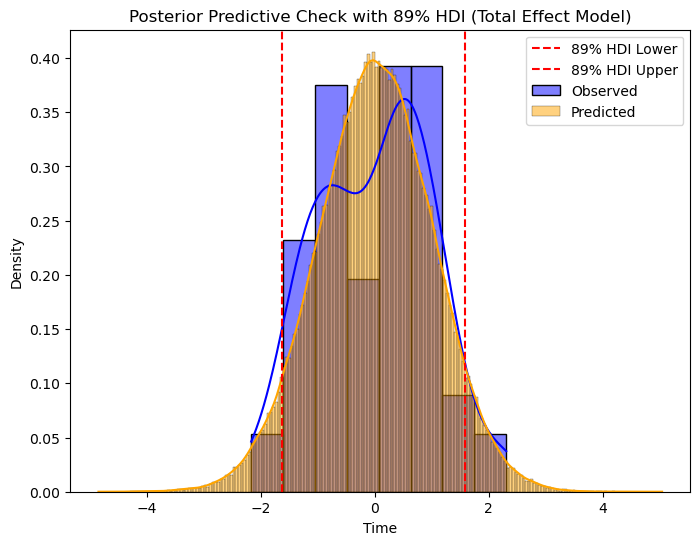

89% HDI for predicted times: [-1.6338794   1.57782728]


In [60]:
with posterior_model_total_effect:
    posterior_predictive_total = pm.sample_posterior_predictive(
        idata_posterior_model_total_effect, 
        random_seed=rnd_seed,
    )

T = posterior_predictive_total["posterior_predictive"]["t"]
predicted_time = T.values.reshape(-1)
hdi_bounds = az.hdi(predicted_time, hdi_prob=0.89)
plt.figure(figsize=(8, 6))
sns.histplot(df_food_delivery['time'], kde=True, label="Observed", color="blue", stat="density")
sns.histplot(predicted_time, kde=True, label="Predicted", color="orange", stat="density")


plt.axvline(hdi_bounds[0], color="red", linestyle="--", label="89% HDI Lower")
plt.axvline(hdi_bounds[1], color="red", linestyle="--", label="89% HDI Upper")
plt.title("Posterior Predictive Check with 89% HDI (Total Effect Model)")
plt.xlabel("Time")
plt.ylabel("Density")
plt.legend()
plt.show()
print(f"89% HDI for predicted times: {hdi_bounds}")

Sampling: [t]


/opt/conda/envs/fnds/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/fnds/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


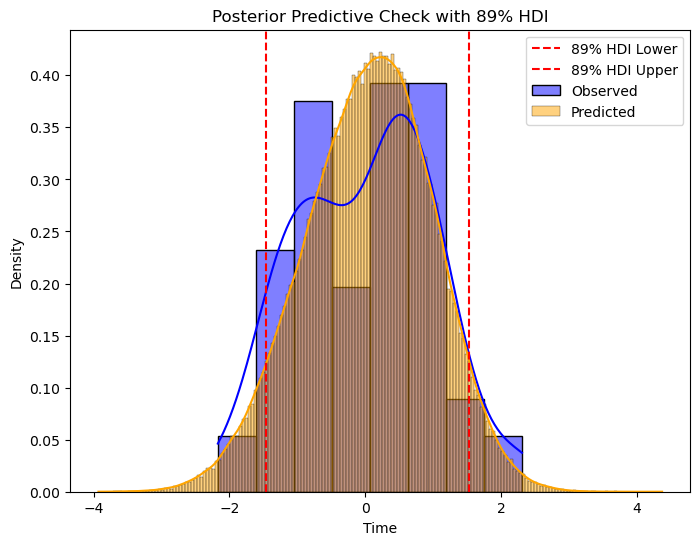

89% HDI for predicted times: [-1.45979324  1.53082118]


In [61]:
with posterior_model_direct_effect:
    posterior_predictive_direct = pm.sample_posterior_predictive(
        idata_posterior_model_direct_effect, 
        random_seed=rnd_seed,
    )

T = posterior_predictive_direct["posterior_predictive"]["t"]
predicted_time = T.values.reshape(-1)
hdi_bounds = az.hdi(predicted_time, hdi_prob=0.89)

plt.figure(figsize=(8, 6))
sns.histplot(df_food_delivery['time'], kde=True, label="Observed", color="blue", stat="density")
sns.histplot(predicted_time, kde=True, label="Predicted", color="orange", stat="density")

plt.axvline(hdi_bounds[0], color="red", linestyle="--", label="89% HDI Lower")
plt.axvline(hdi_bounds[1], color="red", linestyle="--", label="89% HDI Upper")
plt.title("Posterior Predictive Check with 89% HDI")
plt.xlabel("Time")
plt.ylabel("Density")
plt.legend()
plt.show()

print(f"89% HDI for predicted times: {hdi_bounds}")

#### Posterior predictive check

- These plots compare the observed distribution (blue) and the posterior predictive distribution (orange) of the `time` variable.
The close alignment between the observed and predicted distributions demonstrates that the posterior approximation fits the observed data reasonably well.

- The total effect model has a slightly larger HDI interval (3.212) compared to the direct effect model (2.99). This indicates that the direct effect model produces estimates with marginally higher precision, as its posterior distribution is narrower and more concentrated.

Overall, the posterior predictive check results indicate that the posterior approximations from both models fit the observed data effectively, but subtle differences could inform model preference or further refinement.

## Discussion

### Comparing the models

In [62]:
with posterior_model_direct_effect:
    idata_posterior_model_direct_effect = pm.compute_log_likelihood(idata_posterior_model_direct_effect, extend_inferencedata=True)
with posterior_model_total_effect:
    idata_posterior_model_total_effect = pm.compute_log_likelihood(idata_posterior_model_total_effect, extend_inferencedata=True)
        
model = {
    "posterior_model_direct_effect":idata_posterior_model_direct_effect,
    "posterior_model_total_effect": idata_posterior_model_total_effect
}
compare_psis_models = az.compare(compare_dict=model,ic="loo",scale="deviance")
compare_psis_models

/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'deviance' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
posterior_model_direct_effect,0,228.899643,12.543112,0.000000,1.0,13.583457,0.000000,False,deviance
posterior_model_total_effect,1,273.815427,5.698838,44.915784,0.0,13.890476,10.191305,False,deviance


/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


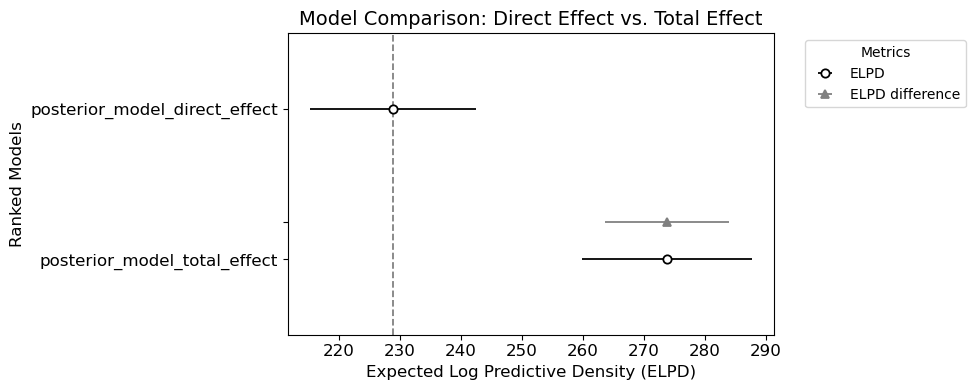

In [63]:
fig, ax = plt.subplots(figsize=(10, 4)) 
az.plot_compare(compare_psis_models, 
                figsize=(6, 6), 
                ax=ax, 
                textsize=12)  

ax.set_title("Model Comparison: Direct Effect vs. Total Effect", fontsize=14)
ax.set_xlabel("Expected Log Predictive Density (ELPD)", fontsize=12)
ax.set_ylabel("Ranked Models", fontsize=12)
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), title="Metrics", fontsize=10)
plt.tight_layout()
plt.show()

In [71]:
mod_psis_direct = az.loo(idata_posterior_model_direct_effect, pointwise=True, scale="deviance")
mod_psis_total = az.loo(idata_posterior_model_total_effect, pointwise=True, scale="deviance")

pd.DataFrame({
    "mod_psis_direct": mod_psis_direct.pareto_k,
    "mod_psis_total": mod_psis_total.pareto_k
})

,mod_psis_direct,mod_psis_total
0,0.016199,-0.000854
1,0.062248,-0.011211
2,0.334432,0.103597
3,0.038169,0.024310
4,0.240754,0.013078
...,...,...
95,0.268156,0.140312
96,0.233074,0.152692
97,0.219489,0.188241
98,0.230567,0.146781


### Model Comparison Results

1. **Model Performance Based on LOO:**
   - The **direct effect model** achieves an ELPD of **228.90**, outperforming the **total effect model** with an ELPD of **273.82**.
   - The lower ELPD for the direct effect model indicates it better captures the predictive structure of the data and aligns more closely with observed outcomes.

2. **Model Performance Based on Pareto \(k\):**
   - The **direct effect model** has Pareto \(k\) values ranging up to **0.334**, well below the threshold of **0.7**, demonstrating stable and reliable LOO estimates.
   - The **total effect model** also shows stable Pareto \(k\) values, ranging up to **0.188**, below the same threshold, confirming acceptable reliability.

3. **Comparison and Conclusion:**
   - While both models exhibit stability, the **direct effect model** is more robust with consistently lower Pareto \(k\) values and superior alignment with the data.
   - This makes the **direct effect model** the preferred choice for capturing the causal impact of weather on delivery times, effectively addressing the confounding role of traffic density.

   

The discussion above provides insights into the causal relationships between weather, traffic density, and delivery times:

1. The direct effect model isolates the pure effect of weather on delivery times, controlling for traffic density.
2. The total effect model captures both the direct effect and the mediated effects of weather through traffic density.
3. The comparison of models clarifies the distinct and combined roles of weather and traffic in influencing delivery times, addressing the question comprehensively.

---

The traffic density is explicitly discussed as a confounding variable:

1. It is influenced by weather and directly impacts delivery times.
2. In the direct effect model, traffic is treated as a control variable, isolating the effect of weather.Adjustment for traffic density is critical here to prevent bias.
3. In the total effect model, traffic is part of the causal pathway, capturing the mediated effect of weather on delivery times.No adjustment for traffic is required in this model, as the mediated effects are part of the causal mechanism.

The distinction between models ensures that traffic's influence is accounted for, avoiding bias in estimating weather's impact. Addressing traffic density enhances the validity of causal interpretations, separating pure and mediated effects of weather on delivery times.

---

The following conclusions are well-supported by model results:

1. Posterior Predictive Checks: Both models fit the observed data, with the direct effect model being slightly better.
2. Model Comparison: LOO and Pareto k metrics indicate that the direct effect model performs better, supporting its ability to explain the data.
3. Posterior Estimates: HDIs for parameters like alpha provide statistical evidence for the causal effects of weather.
4. Causal Pathways: The direct effect model isolates pure effects, while the total effect model captures broader, mediated relationships.

These findings align with the hypothesis, confirming weather's direct and indirect impacts on delivery times.

### Summary

The research question explores how weather conditions causally influence food delivery times, with traffic density acting as a confounding factor. Traffic density is a confounder as it is influenced by weather and directly impacts delivery times.

#### Key Insights

1. **Direct Effect Model**  
   This model controls for traffic density to isolate the pure causal effect of weather on delivery times:
   - **Fog** increases delivery times during high traffic (Mean: 0.674, 89% HDI: [0.355, 0.975]).
   - **Sunny conditions** consistently reduce delivery times across all traffic levels (Mean: -0.652, 89% HDI: [-1.089, -0.269]).
   - **Stormy weather** increases delivery times during high traffic but shows minimal impact during low traffic.

2. **Total Effect Model**  
   This model includes traffic density as a mediator to capture both direct and indirect effects of weather:
   - **Sunny weather** significantly reduces delivery times (Mean: -0.799, 89% HDI: [-1.216, -0.448]).
   - **Sandstorms and storms** increase delivery times directly and through traffic congestion.

3. **Model Comparison**  
   - **ELPD (Expected Log Predictive Density):**  
     The direct effect model outperforms the total effect model, with a lower ELPD (228.90 vs. 273.82), indicating better predictive accuracy when controlling for traffic.
   - **Pareto \(k\) Diagnostics:**  
     Both models exhibit Pareto \(k\) values below 0.7, indicating stable LOO estimates. However, the direct effect model has lower values, showing better robustness against influential observations.
   - **HDI Intervals:**  
     The direct effect model has narrower HDI intervals, reflecting greater precision (e.g., Sunny: [-1.089, -0.269]), while the total effect model captures broader effects with wider intervals.
   - **Posterior Predictive Checks:**  
     Both models align well with observed data, but the direct effect model performs slightly better, particularly for adverse weather.

Weather impacts delivery times differently across traffic levels. Sunny weather consistently reduces delivery times, particularly in medium and low-traffic conditions, while fog causes delays in high traffic but reduces times in lower traffic. Stormy and cloudy weather delay deliveries in high traffic but have minimal or mixed effects in lower traffic scenarios. Sandstorms and windy conditions slightly increase delays in higher traffic but have negligible impact in low traffic. 
These insights enable businesses to optimize delivery scheduling, prioritize deliveries during favorable weather, and mitigate delays through strategic traffic and weather-aware planning.

# **Future Scope**
 
## **1. Improving Current Models**
### **Refining Existing Models**
- **Hierarchical Bayesian Models** (Chapter 13, *Statistical Rethinking*):
  - Capture group-specific variations, such as how weather impacts delivery times across different `Delivery Location Types` (urban, suburban, rural).
- **Mediation Analysis** (Chapter 6, *Statistical Rethinking*):
  - Disentangle the causal effects of `Weather Conditions` on `Delivery Time`, mediated through `Traffic Density`.
 
### **Potential Variables to Add (From Existing Features)**
1. **Order Time**:
   - **Rush Hours**:
     - Binary variable to indicate whether the order was placed during peak traffic hours (e.g., morning/evening rush).
   - **Day of the Week**:
     - Categorical variable to capture variations in delivery times on weekdays vs. weekends.
2. **Distance**:
   - **Categorized Distance**:
     - Group delivery distances into short, medium, and long ranges to analyze their varying effects on delivery time under different weather conditions.
3. **Weather Conditions**:
   - **Adverse Weather Indicator**:
     - Binary variable to flag extreme weather conditions (e.g., stormy or foggy) versus normal conditions (e.g., sunny, cloudy).
4. **Delivery Location Type**:
   - **Urban vs. Non-Urban Indicator**:
     - Binary variable to differentiate urban locations from suburban or rural ones for analyzing location-specific delivery challenges.
5. **Traffic Density**:
   - **Categorized Traffic Levels**:
     - Group traffic density into low, medium, and high to understand its compounding effects with weather and distance.
 
---
 
## **2. Broader Business Questions to Solve**
 
### **Impact of Weather on Delivery Time Across Locations**
- **Question**: How does weather affect delivery times differently in urban, suburban, and rural areas?
- **Why it Matters**: Location-specific insights can optimize resource allocation, allowing targeted interventions under adverse weather conditions.
- **How**: Extend the current models using hierarchical structures to estimate separate effects for different `Delivery Location Types`.
 
### **Causal Effect of Time of Day on Delivery Efficiency**
- **Question**: What is the causal impact of order time on delivery times, considering weather and traffic conditions?
- **Why it Matters**: Identifying peak hours and weather dependencies enables better driver scheduling and resource allocation.
- **How**: Introduce `Order Time` as a moderator in a hierarchical Bayesian model, capturing time-of-day effects under varying weather conditions.
 
### **Predicting On-Time Deliveries**
- **Question**: What factors (weather, traffic, time of day) most strongly affect the likelihood of on-time delivery?
- **Why it Matters**: Predictive insights can guide real-time decision-making, improving customer satisfaction by anticipating delays.
- **How**: Use a Bayesian logistic regression model to predict the binary outcome of on-time/delayed deliveries, incorporating `Weather`, `Traffic Density`, and `Order Time`.
 
### **Driver Efficiency Across Conditions**
- **Question**: How does driver performance vary under different weather and traffic conditions?
- **Why it Matters**: Understanding driver efficiency under adverse conditions can inform training programs and task assignments, improving overall delivery performance.
- **How**: Include driver-specific random effects in a hierarchical model to account for variability in performance across different weather and traffic scenarios.